In [2]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import colors 
import evaluation.evaluate as evaluate
from tqdm import tqdm

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [4]:
def load_audio_for_classification(fileListName, datasetName, dataDirectory, pathToDataDir="./../data/", overallLength = 10, partLength=1):
    labelDf = pd.read_csv(pathToDataDir+fileListName)
    labelDf = labelDf.replace({"event_label": bbdc.LABEL_DICT})
    labelDf['duration'] = labelDf.offset - labelDf.onset
    
    first_file_string = '/' + labelDf['filename'][0][:-4] + '.csv'
    ## Features aller Files laden
    X = []
    Y = []
    fileList = []
    first_file_string = '/'+dataDirectory+'/' + labelDf['filename'][0][:-4] + '.csv'
    timepoints = np.genfromtxt(pathToDataDir+datasetName+first_file_string, delimiter=',')[:, 0]
    sizeOfSequences = int(partLength/overallLength*len(timepoints))
    currentFile = ""
    for index, row in tqdm(labelDf.iterrows()):
        if currentFile!=row["filename"]:
            currentFile = row["filename"].replace(".wav", ".csv")
            features = np.genfromtxt(pathToDataDir + datasetName + dataDirectory+currentFile, delimiter=',')
        partOfFeatures = features[np.where(np.logical_and(timepoints >= row["onset"],timepoints <= row["offset"]))]
        if len(partOfFeatures)<=sizeOfSequences:
            indices = np.where(np.logical_and(timepoints >= row["onset"],timepoints <= row["offset"]))[0]
            fileList.append(currentFile)
            X.append(features[indices[0]:indices[0]+sizeOfSequences, 1:])
            y = np.zeros(len(bbdc.LABEL_DICT))
            y[row["event_label"]]=1
            Y.append(y)
        elif len(partOfFeatures)>sizeOfSequences:
            fileList.append(currentFile)
            fileList.append(currentFile)
            X.append(partOfFeatures[:sizeOfSequences, 1:])
            X.append(partOfFeatures[-sizeOfSequences:, 1:])
            y = np.zeros(len(bbdc.LABEL_DICT))
            y[row["event_label"]]=1
            Y.append(y)
            Y.append(y)
    return np.array(X), np.array(Y), fileList

In [6]:
X_train_a, Y_train_a, trainFileList_a = bbdc.load_audioset("long_unbalanced_train_segments.csv", "unbalanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_validation_a, Y_validation_a, validationFileList_a = bbdc.load_audioset("long_balanced_train_segments.csv", "balanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_test_a, Y_test_a, testFileList_a = bbdc.load_audioset("long_eval_segments.csv", "eval_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")

16186it [08:12, 32.85it/s]
573it [00:17, 32.30it/s]
585it [00:17, 32.61it/s]


In [9]:
Y_train_a[:,0]=0
Y_validation_a[:,0]=0
Y_test_a[:,0]=0

X_train_new = np.append(X_train_a, X_validation_a, axis=0)
X_train_new = np.append(X_train_new, X_test_a, axis=0)
Y_train_new = np.append(Y_train_a, Y_validation_a, axis=0)
Y_train_new = np.append(Y_train_new, Y_test_a, axis=0)

shuffledIndices = np.random.permutation(X_train_new.shape[0])
X_train_new = X_train_new[shuffledIndices]
Y_train_new = Y_train_new[shuffledIndices]
length = len(shuffledIndices)
X_validation_new = X_train_new[int(0.8*length):int(0.9*length)]
Y_validation_new = Y_train_new[int(0.8*length):int(0.9*length)]
X_test_new = X_train_new[int(0.9*length):]
Y_test_new = Y_train_new[int(0.9*length):]
X_train_new = X_train_new[:int(0.8*length)]
Y_train_new = Y_train_new[:int(0.8*length)]

In [10]:
X_train, Y_train, trainFileList = load_audio_for_classification("train.csv", pathToDataset, "dev/")
X_validation, Y_validation, validationFileList = load_audio_for_classification("validation.csv", pathToDataset, "dev/")
X_test, Y_test, testFileList = load_audio_for_classification("test.csv", pathToDataset, "dev/")

24009it [04:50, 82.62it/s]
3047it [00:35, 86.42it/s]
2988it [00:34, 87.03it/s]


In [11]:
channels = [32, 64, 30]
numClasses=13
padding = "same"
input_layer = layers.Input(shape=(None, 32))
#input_layer = layers.Input(shape=X_train_new[0].shape)
x = input_layer
x = layers.LSTM(100)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(numClasses, activation="softmax")(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                429       
Total params: 66,961
Trainable params: 66,961
Non-trainable params: 0
_________________________________________________________

In [32]:
channels = [25, 20, 15]
numClasses=13
padding = "same"
input_layer = layers.Input(shape=(None, 32))
#input_layer = layers.Input(shape=X_train_new[0].shape)
x = input_layer
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Activation(keras.activations.softmax)(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 25)          2425      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 25)          1900      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 25)          100       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 25)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 20)          1520      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 20)          1220

In [37]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train_new, Y_train_new, batch_size=64, epochs=150, shuffle=True, validation_data=(X_validation_new, Y_validation_new), callbacks=[checkpoint])

Epoch 1/150
217/217 [==============================] - 4s 13ms/step - loss: 4.1450 - mae: 0.1019 - accuracy: 0.3644 - val_loss: 2.7526 - val_mae: 0.0962 - val_accuracy: 0.4175

Epoch 00001: val_loss improved from inf to 2.75265, saving model to model.h5
Epoch 2/150
217/217 [==============================] - 2s 11ms/step - loss: 2.1709 - mae: 0.0922 - accuracy: 0.4571 - val_loss: 1.9797 - val_mae: 0.0904 - val_accuracy: 0.4746

Epoch 00002: val_loss improved from 2.75265 to 1.97972, saving model to model.h5
Epoch 3/150
217/217 [==============================] - 2s 11ms/step - loss: 1.7751 - mae: 0.0899 - accuracy: 0.4959 - val_loss: 1.7446 - val_mae: 0.0886 - val_accuracy: 0.5087

Epoch 00003: val_loss improved from 1.97972 to 1.74458, saving model to model.h5
Epoch 4/150
217/217 [==============================] - 2s 11ms/step - loss: 1.5860 - mae: 0.0877 - accuracy: 0.5264 - val_loss: 1.6250 - val_mae: 0.0842 - val_accuracy: 0.5496

Epoch 00004: val_loss improved from 1.74458 to 1.6249

In [38]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, shuffle=True, validation_data=(X_validation, Y_validation), callbacks=[checkpoint])

Epoch 1/100
563/563 [==============================] - 5s 7ms/step - loss: 2.5101 - mae: 0.0838 - accuracy: 0.4838 - val_loss: 1.6686 - val_mae: 0.0686 - val_accuracy: 0.5952

Epoch 00001: val_loss improved from inf to 1.66860, saving model to model.h5
Epoch 2/100
563/563 [==============================] - 3s 6ms/step - loss: 1.5404 - mae: 0.0675 - accuracy: 0.6054 - val_loss: 1.3327 - val_mae: 0.0613 - val_accuracy: 0.6516

Epoch 00002: val_loss improved from 1.66860 to 1.33270, saving model to model.h5
Epoch 3/100
563/563 [==============================] - 4s 6ms/step - loss: 1.2484 - mae: 0.0604 - accuracy: 0.6608 - val_loss: 1.1590 - val_mae: 0.0572 - val_accuracy: 0.6803

Epoch 00003: val_loss improved from 1.33270 to 1.15897, saving model to model.h5
Epoch 4/100
563/563 [==============================] - 4s 6ms/step - loss: 1.0894 - mae: 0.0560 - accuracy: 0.6904 - val_loss: 1.0476 - val_mae: 0.0539 - val_accuracy: 0.6983

Epoch 00004: val_loss improved from 1.15897 to 1.04762, s

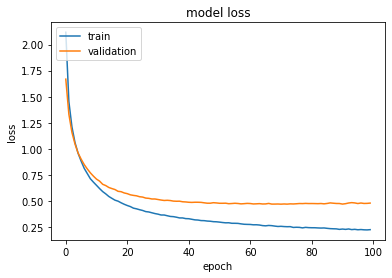

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

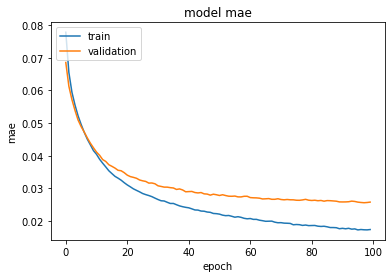

In [40]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

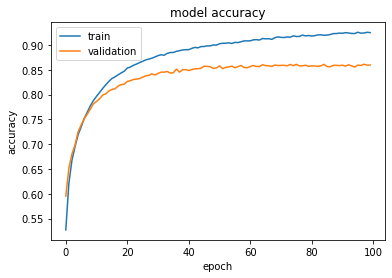

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
model.save("classificationBBDC_Data_100.h5")

In [ ]:
model = keras.models.load_model("model.h5")

In [20]:
prediction = model.predict(X_test)
scores = model.evaluate(X_test, Y_test)

140/140 [==============================] - 0s 3ms/step - loss: 1.0421 - mae: 0.0691 - accuracy: 0.6585


In [22]:
index = 5
print(bbdc.invLabelMap[np.argmax(prediction[index])])
print(bbdc.invLabelMap[np.argmax(Y_test[index])])

Meow
Meow


# Prediction der Test-Daten

In [23]:
firstPredictionFile = "../predictions/jannes/LP1d_Prediction_mel_pp_test.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPrediction.head()

,filename,onset,offset,event_label
0,09001_mix.wav,1.152882,2.280702,Cough
1,09001_mix.wav,2.305764,3.107769,Fireworks
2,09001_mix.wav,3.884712,5.889724,Cheering
3,09001_mix.wav,7.819549,9.724311,Meow
4,09002_mix.wav,0.225564,0.877193,Shout


In [24]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/dev/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [25]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

In [26]:
secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]

In [27]:
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPrediction.csv", index=False)

In [28]:
print("Score was: ")
print(evaluate.evaluate(firstPredictionFile, "./../data/test.csv"))
print("Score now is: ")
print(evaluate.evaluate("../predictions/jannes/secondPrediction.csv", "./../data/test.csv"))

Score was: 
(0.831134109757114, 'Valid file')
Score now is: 
(0.7921372736988144, 'Valid file')


# Prediction der gesamten Trainingsdaten

In [53]:
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPredictionFile = pathToDataDir+pathToDataset+"dev-labels.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
firstPrediction.head()

,filename,onset,offset,event_label
0,00001_mix.wav,2.852143,3.852143,Cheering
1,00001_mix.wav,5.468056,6.468056,Church_bell
2,00002_mix.wav,0.433088,1.433088,Doorbell
3,00002_mix.wav,2.510292,3.510292,Shatter
4,00002_mix.wav,5.106170,6.106170,Church_bell


In [54]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/dev/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [42]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPrediction.csv", index=False)
print("Score now is: ")
print(evaluate.evaluate("../predictions/jannes/secondPrediction.csv", pathToDataDir+pathToDataset+"dev-labels.csv"))

Score now is: 
(nan, "Each file needs to have at least one label. 10000 file(s) missing, e.g. ['02224_mix.wav', '05618_mix.wav', '01720_mix.wav']")


# Prediction der Challenge-Daten

In [21]:
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPredictionFile = "../data/challenge_dummyWithTime.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
firstPrediction.head()

,filename,onset,offset,event_label
0,10001_mix.wav,2.857143,3.834586,?
1,10001_mix.wav,5.488722,6.466165,?
2,10001_mix.wav,7.969925,8.546366,?
3,10001_mix.wav,9.573935,9.774436,?
4,10002_mix.wav,0.451128,3.483709,?


In [22]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/eval/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.where(np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"]))[0]
    start = indices[0]
    end = indices[-1]
    while end-start<44:
        start = start-10
        end = end+10
        if end>=len(features):
            end = len(features)
        if start<0:
            start=0
    X.append(features[start:end, 1:])

In [56]:
X[0].shape

(59, 32)

In [43]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append("?")
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append("short")
        print("too short")

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPredictionChallenge.csv", index=False)

In [24]:
secondPredictionDf.head(20)

,filename,onset,offset,event_label
0,10001_mix.wav,2.857143,3.834586,Scratching_(performance_technique)
1,10001_mix.wav,5.488722,6.466165,Cough
2,10001_mix.wav,7.969925,8.546366,Camera
3,10001_mix.wav,9.573935,9.774436,Camera
4,10002_mix.wav,0.451128,3.483709,Scratching_(performance_technique)
5,10002_mix.wav,5.112782,6.115288,Scratching_(performance_technique)
6,10002_mix.wav,7.619048,8.696742,Cough
7,10003_mix.wav,0.902256,1.203008,Cough
8,10003_mix.wav,2.581454,4.561404,Cheering
9,10003_mix.wav,5.238095,6.215539,Fireworks


In [ ]:
secondPredictionDf.head(20)